# Trabajo 01: Optimización heurística

Parte 2: optimización combinatoria

Código tomado de [Ant Colony Optimization](https://github.com/johnberroa/Ant-Colony-Optimization/blob/master/AntColonyOptimizer.py). Todos los créditos son de [Jerzy Pawlikowski](https://github.com/jerzypawlikowski).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

import warnings

warnings.filterwarnings("ignore")


class AntColonyOptimizer:
    def __init__(self, ants, evaporation_rate, intensification, alpha=1.0, beta=0.0, beta_evaporation_rate=0,
                 choose_best=.1):
        """
        Ant colony optimizer.  Traverses a graph and finds either the max or min distance between nodes.
        :param ants: number of ants to traverse the graph
        :param evaporation_rate: rate at which pheromone evaporates
        :param intensification: constant added to the best path
        :param alpha: weighting of pheromone
        :param beta: weighting of heuristic (1/distance)
        :param beta_evaporation_rate: rate at which beta decays (optional)
        :param choose_best: probability to choose the best route
        """
        # Parameters
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.pheromone_intensification = intensification
        self.heuristic_alpha = alpha
        self.heuristic_beta = beta
        self.beta_evaporation_rate = beta_evaporation_rate
        self.choose_best = choose_best

        # Internal representations
        self.pheromone_matrix = None
        self.heuristic_matrix = None
        self.probability_matrix = None

        self.map = None
        self.set_of_available_nodes = None

        # Internal stats
        self.best_series = []
        self.best = None
        self.fitted = False
        self.best_path = None
        self.fit_time = None

        # Plotting values
        self.stopped_early = False

    def __str__(self):
        string = "Ant Colony Optimizer"
        string += "\n--------------------"
        string += "\nDesigned to optimize either the minimum or maximum distance between nodes in a square matrix that behaves like a distance matrix."
        string += "\n--------------------"
        string += "\nNumber of ants:\t\t\t\t{}".format(self.ants)
        string += "\nEvaporation rate:\t\t\t{}".format(self.evaporation_rate)
        string += "\nIntensification factor:\t\t{}".format(self.pheromone_intensification)
        string += "\nAlpha Heuristic:\t\t\t{}".format(self.heuristic_alpha)
        string += "\nBeta Heuristic:\t\t\t\t{}".format(self.heuristic_beta)
        string += "\nBeta Evaporation Rate:\t\t{}".format(self.beta_evaporation_rate)
        string += "\nChoose Best Percentage:\t\t{}".format(self.choose_best)
        string += "\n--------------------"
        string += "\nUSAGE:"
        string += "\nNumber of ants influences how many paths are explored each iteration."
        string += "\nThe alpha and beta heuristics affect how much influence the pheromones or the distance heuristic weigh an ants' decisions."
        string += "\nBeta evaporation reduces the influence of the heuristic over time."
        string += "\nChoose best is a percentage of how often an ant will choose the best route over probabilistically choosing a route based on pheromones."
        string += "\n--------------------"
        if self.fitted:
            string += "\n\nThis optimizer has been fitted."
        else:
            string += "\n\nThis optimizer has NOT been fitted."
        return string

    def _initialize(self):
        """
        Initializes the model by creating the various matrices and generating the list of available nodes
        """
        assert self.map.shape[0] == self.map.shape[1], "Map is not a distance matrix!"
        num_nodes = self.map.shape[0]
        self.pheromone_matrix = np.ones((num_nodes, num_nodes))
        # Remove the diagonal since there is no pheromone from node i to itself
        self.pheromone_matrix[np.eye(num_nodes) == 1] = 0
        self.heuristic_matrix = 1 / self.map
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
                self.heuristic_matrix ** self.heuristic_beta)  # element by element multiplcation
        self.set_of_available_nodes = list(range(num_nodes))

    def _reinstate_nodes(self):
        """
        Resets available nodes to all nodes for the next iteration
        """
        self.set_of_available_nodes = list(range(self.map.shape[0]))

    def _update_probabilities(self):
        """
        After evaporation and intensification, the probability matrix needs to be updated.  This function
        does that.
        """
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
                self.heuristic_matrix ** self.heuristic_beta)

    def _choose_next_node(self, from_node):
        """
        Chooses the next node based on probabilities.  If p < p_choose_best, then the best path is chosen, otherwise
        it is selected from a probability distribution weighted by the pheromone.
        :param from_node: the node the ant is coming from
        :return: index of the node the ant is going to
        """
        numerator = self.probability_matrix[from_node, self.set_of_available_nodes]
        if np.random.random() < self.choose_best:
            next_node = np.argmax(numerator)
        else:
            denominator = np.sum(numerator)
            probabilities = numerator / denominator
            next_node = np.random.choice(range(len(probabilities)), p=probabilities)
        return next_node

    def _remove_node(self, node):
        self.set_of_available_nodes.remove(node)

    def _evaluate(self, paths, mode):
        """
        Evaluates the solutions of the ants by adding up the distances between nodes.
        :param paths: solutions from the ants
        :param mode: max or min
        :return: x and y coordinates of the best path as a tuple, the best path, and the best score
        """
        scores = np.zeros(len(paths))
        coordinates_i = []
        coordinates_j = []
        for index, path in enumerate(paths):
            score = 0
            coords_i = []
            coords_j = []
            for i in range(len(path) - 1):
                coords_i.append(path[i])
                coords_j.append(path[i + 1])
                score += self.map[path[i], path[i + 1]]
            scores[index] = score
            coordinates_i.append(coords_i)
            coordinates_j.append(coords_j)
        if mode == 'min':
            best = np.argmin(scores)
        elif mode == 'max':
            best = np.argmax(scores)
        return (coordinates_i[best], coordinates_j[best]), paths[best], scores[best]

    def _evaporation(self):
        """
        Evaporate some pheromone as the inverse of the evaporation rate.  Also evaporates beta if desired.
        """
        self.pheromone_matrix *= (1 - self.evaporation_rate)
        self.heuristic_beta *= (1 - self.beta_evaporation_rate)

    def _intensify(self, best_coords):
        """
        Increases the pheromone by some scalar for the best route.
        :param best_coords: x and y (i and j) coordinates of the best route
        """
        i = best_coords[0]
        j = best_coords[1]
        self.pheromone_matrix[i, j] += self.pheromone_intensification

    def fit(self, map_matrix, iterations=100, mode='min', early_stopping_count=20, verbose=True):
        """
        Fits the ACO to a specific map.  This was designed with the Traveling Salesman problem in mind.
        :param map_matrix: Distance matrix or some other matrix with similar properties
        :param iterations: number of iterations
        :param mode: whether to get the minimum path or maximum path
        :param early_stopping_count: how many iterations of the same score to make the algorithm stop early
        :return: the best score
        """
        if verbose: print("Beginning ACO Optimization with {} iterations...".format(iterations))
        self.map = map_matrix
        start = time.time()
        self._initialize()
        num_equal = 0

        for i in range(iterations):
            start_iter = time.time()
            paths = []
            path = []

            for ant in range(self.ants):
                current_node = self.set_of_available_nodes[np.random.randint(0, len(self.set_of_available_nodes))]
                start_node = current_node
                while True:
                    path.append(current_node)
                    self._remove_node(current_node)
                    if len(self.set_of_available_nodes) != 0:
                        current_node_index = self._choose_next_node(current_node)
                        current_node = self.set_of_available_nodes[current_node_index]
                    else:
                        break

                path.append(start_node)  # go back to start
                self._reinstate_nodes()
                paths.append(path)
                path = []

            best_path_coords, best_path, best_score = self._evaluate(paths, mode)

            if i == 0:
                best_score_so_far = best_score
            else:
                if mode == 'min':
                    if best_score < best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path
                elif mode == 'max':
                    if best_score > best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path

            if best_score == best_score_so_far:
                num_equal += 1
            else:
                num_equal = 0

            self.best_series.append(best_score)
            self._evaporation()
            self._intensify(best_path_coords)
            self._update_probabilities()

            if verbose: print("Best score at iteration {}: {}; overall: {} ({}s)"
                              "".format(i, round(best_score, 2), round(best_score_so_far, 2),
                                        round(time.time() - start_iter)))

            if best_score == best_score_so_far and num_equal == early_stopping_count:
                self.stopped_early = True
                print("Stopping early due to {} iterations of the same score.".format(early_stopping_count))
                break

        self.fit_time = round(time.time() - start)
        self.fitted = True

        if mode == 'min':
            self.best = self.best_series[np.argmin(self.best_series)]
            if verbose: print(
                "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        elif mode == 'max':
            self.best = self.best_series[np.argmax(self.best_series)]
            if verbose: print(
                "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        else:
            raise ValueError("Invalid mode!  Choose 'min' or 'max'.")

    def plot(self):
        """
        Plots the score over time after the model has been fitted.
        :return: None if the model isn't fitted yet
        """
        if not self.fitted:
            print("Ant Colony Optimizer not fitted!  There exists nothing to plot.")
            return None
        else:
            fig, ax = plt.subplots(figsize=(20, 15))
            ax.plot(self.best_series, label="Best Run")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Performance")
            ax.text(.8, .6,
                    'Ants: {}\nEvap Rate: {}\nIntensify: {}\nAlpha: {}\nBeta: {}\nBeta Evap: {}\nChoose Best: {}\n\nFit Time: {}m{}'.format(
                        self.ants, self.evaporation_rate, self.pheromone_intensification, self.heuristic_alpha,
                        self.heuristic_beta, self.beta_evaporation_rate, self.choose_best, self.fit_time // 60,
                        ["\nStopped Early!" if self.stopped_early else ""][0]),
                    bbox={'facecolor': 'gray', 'alpha': 0.8, 'pad': 10}, transform=ax.transAxes)
            ax.legend()
            plt.title("Ant Colony Optimization Results (best: {})".format(np.round(self.best, 2)))
            plt.show()

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Fuentes
Los datos de distancia entre ciudades y tiempo aproximado de viaje fueron obtenidos de la pagina http://co.lasdistancias.net

Los datos de costo de los  peajes fueron obtenidos de dos paginas:
https://www.peajesencolombia.com y https://viajaporcolombia.com/peajes


In [ ]:
##Se importa el data frame del tiempo de viaje entre ciudades
import pandas as pd
TdeV = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Tiempo de viaje entre ciudades.xlsx", header=None)
TdeV = TdeV.to_numpy()

##SE importa el data frame del costo de los peajes entre ciudades 
Cpeajes = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/costo peajes entre ciudades.xlsx", header=None)
Cpeajes = Cpeajes.to_numpy()

##Se importa el data frame de ls distancia entre las ciudades
Dist = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Distancia entre ciudades.xlsx", header = None)
Dist = Dist.to_numpy()


In [ ]:
##se multiplica la matriz por el costo del combustible por hora suponiendo que el carro es una camioneta renault orosch que tiene una autonomia de 13.7 Km/l.
Combustible = 13.7*Dist
##Se multiplica la matriz del combustible consumido por el costo promedio de un litro de gasolina corriente:COP 2,844.080 
Combustible = Combustible*2844.080


In [ ]:
##Se multiplica el tiempo estimado de viaje por el costo de la hora de trabajo en el salario minimo: COP 4833
TdeV = TdeV*4833

In [ ]:
##Se suman los tres arreglos para optener la matriz del costo total del viaje entre ciudades
Total = TdeV+Combustible+Cpeajes


###Lista de Ciudades
0: Palmira

1:Pasto

2: Tuluá

3: Bogotá

4: pereira

5: Armenia

6: Manizales

7: Valledupar

8: Montería

9: Soledad

10: Cartagena

11: Barranquilla

12: Medellín

13: Bucaramanga

14: Cucuta

Beginning ACO Optimization with 100 iterations...
Best score at iteration 0: 143343824.39; overall: 143343824.39 (0s)
Best score at iteration 1: 151554800.05; overall: 143343824.39 (0s)
Best score at iteration 2: 129213692.76; overall: 129213692.76 (0s)
Best score at iteration 3: 141531512.78; overall: 129213692.76 (0s)
Best score at iteration 4: 129213692.76; overall: 129213692.76 (0s)
Best score at iteration 5: 127722079.62; overall: 127722079.62 (0s)
Best score at iteration 6: 139563676.92; overall: 127722079.62 (0s)
Best score at iteration 7: 132947922.15; overall: 127722079.62 (0s)
Best score at iteration 8: 140723401.14; overall: 127722079.62 (0s)
Best score at iteration 9: 126698595.95; overall: 126698595.95 (0s)
Best score at iteration 10: 133374106.95; overall: 126698595.95 (0s)
Best score at iteration 11: 135955375.34; overall: 126698595.95 (0s)
Best score at iteration 12: 121960816.46; overall: 121960816.46 (0s)
Best score at iteration 13: 120687558.29; overall: 120687558.29

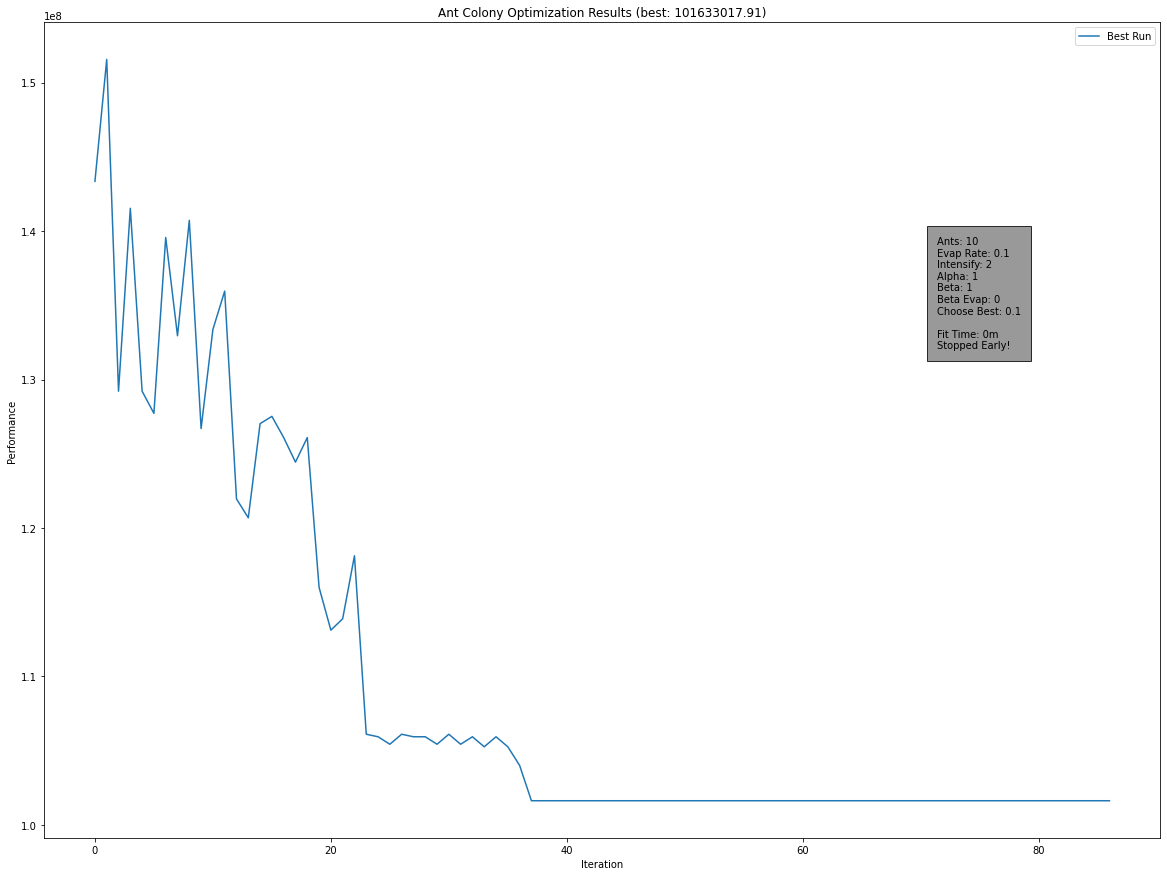

In [ ]:
problem = Total
optimizer = AntColonyOptimizer(ants=10, evaporation_rate=.1, intensification=2, alpha=1, beta=1,
                               beta_evaporation_rate=0, choose_best=.1)
 
best = optimizer.fit(problem, 100)
optimizer.plot()

In [ ]:
optimizer.best_path

[0, 1, 3, 13, 14, 7, 9, 11, 10, 8, 12, 6, 4, 5, 2, 0]

In [ ]:
!pip install pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 KB 1.8 MB/s eta 0:00:00


In [ ]:
import pygad

# Matriz de distancias
distance_matrix = Total
gene_space = [x for x in range(15)]

# Función de aptitud para TSP
def tsp_fitness(solution, solution_idx):
    fitness = 0
    for i in range(len(solution)):
        fitness += distance_matrix[int(solution[i-1])][int(solution[i])]
    return 1/fitness

# Configuración de la optimización genética
ga_instance = pygad.GA(num_generations=500, 
                       sol_per_pop=50, 
                       num_genes=len(distance_matrix), 
                       fitness_func=tsp_fitness,
                       crossover_type="two_points",
                       mutation_type="swap",
                       num_parents_mating=25,
                       parent_selection_type = "tournament",
                       gene_space=gene_space,
                       allow_duplicate_genes=False,
                       mutation_percent_genes=5)

# Ejecutar la optimización
ga_instance.run()

# Obtener la mejor solución encontrada
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("La mejor solución encontrada es:", solution)
print("Con un costo total de:", solution_fitness)

La mejor solución encontrada es: [ 9.  8. 12.  2.  0.  1.  4.  5.  6.  3. 13. 14.  7. 10. 11.]
Con una distancia total de: 8.794711232203361e-09


In [ ]:
suma = 0
for i in range(1,len(solution)):
  a = int(solution[i-1])
  b = int(solution[i])
  suma += Total[a][b]

suma += Total[int(solution[-1])][int(solution[0])]
print(suma)

113704699.744811
